# kergp with functional inputs

In this notebook, we aim at predicting an unobserved spatial map using data from a predefined learning set of maps.

First, we load some packages and define useful functions:

In [1]:
library(kergp)       # modified kergp package
library(plot3D)      # package for graphics and visualisations
library(ggplot2)     # package for graphics and visualisations
library(pals)        # package for graphics and visualisations
library(repr)        # package for graphics and visualisations

rm(list = ls())      # cleaning global environment

## local functions to account for functional data ##
source("rscripts/kernelsi.R")
source("rscripts/corkernelfi.R")
source("rscripts/basisCompute.R")
source("rscripts/futils.R")

## defining the color palette ##
colormap <- viridis(100)
set.seed(4)

Loading required package: Rcpp
Loading required package: testthat
Loading required package: nloptr
Loading required package: lattice
Loading required package: maps


In [2]:
## sampling from a Gaussian distribution using Chilesky matrix ##
mvrnormChol <- function(n = 1, mu = rep(0, nrow(L)), L) {
  d <- nrow(L)
  v <- matrix(rnorm(d*n), d, n)
  x <- t(L) %*% v + matrix(mu, d, n)
  return(t(x))
}

## 1D Matern 5/2 kernel ##
kMatern52 <- function(t1, t2 = t1, par) {
  # t1, t2 = vectors with time instants
  # par = (variance, lengthscale)
  sigma2 <- par[1]; theta <- par[2]
  
  # precomputing some terms
  dist2 <- outer(t1[, 1]/theta, t2[, 1]/theta, '-')^2
  sqrt5dist <- sqrt(5)*sqrt(dist2)
  expSqrt5dist <- exp(-sqrt5dist)
  
  # computing the kernel
  kern <- sigma2*(1 + sqrt5dist + (5/3)*dist2)*expSqrt5dist
  return(kern)
}

We now generate the synthetic data used in this notebook. We sample 101 maps: the first 100 of them are used for training the model and the last one for validation. 

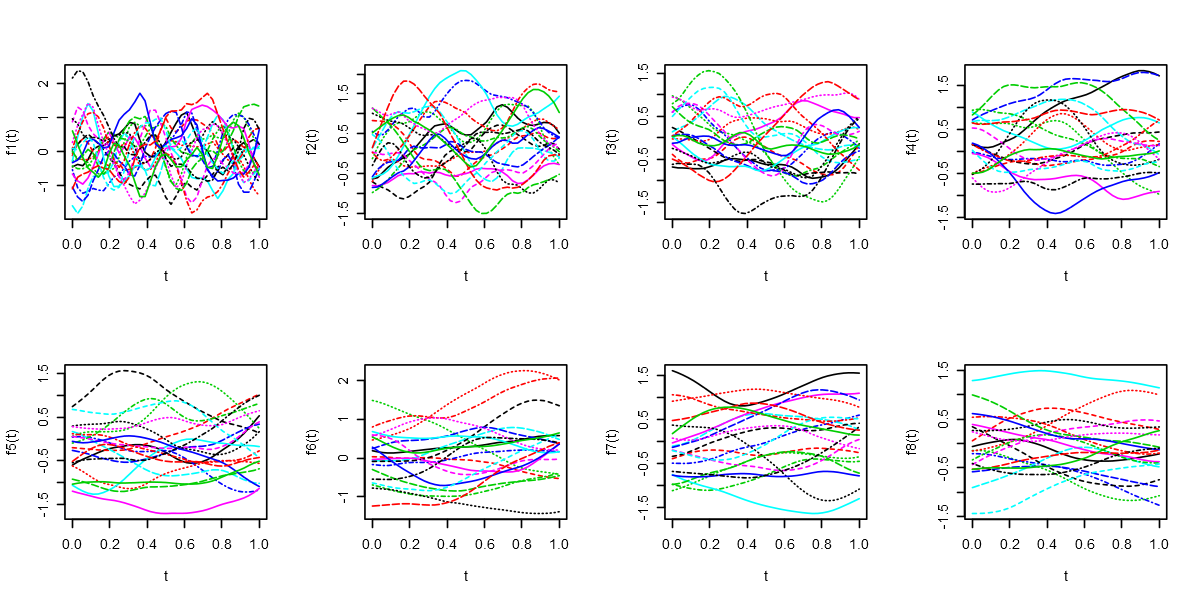

In [3]:
#### building up the toy dataset ####
## sampling random functional profiles ##
nrepTrain <- 100 # nb of functional replicates for training
nrepTest <- 1 # nb of functional replicates for testing
nrep <- nrepTrain + nrepTest

# functional data #
nt <- 37
t <- as.matrix(seq(0, 1, length.out = nt))
dimF <- 8 # dimension of the functional input
ubase <- 1:nrep
parT <- cbind(0.5, seq(0.1, 0.8, length = dimF))

ft <- vector("list", dimF)
par(mfrow = c(2,4))
for (i in 1:dimF) {
    set.seed(i)
    ft[[i]] <- mvrnormChol(nrep, rep(0, nt), chol(kMatern52(t, t, parT[i, ])))
    idxPlot <- seq(1,nrep,5)
    options(repr.plot.width = 10, repr.plot.height = 5)
    matplot(t, t(ft[[i]][idxPlot, ]), type = "l",
            xlab = "t", ylab = paste("f", i, "(t)", sep = ""))
}

In [4]:
## sampling random spatial maps ##
# spatial data #
nb_x <- 1e1 # nb of spatial points per dimension
x1D <- seq(0, 1, length.out = nb_x)
x <- expand.grid(x1 = x1D, x2 = x1D) # grid with spatial points
kernType_x <- "Matern52"
par_x <- c(1, rep(0.2, ncol(x)))
names(par_x) <- c("sigma2_x", paste("theta_x", 1:ncol(x), sep = ""))

# list with functional data #
projType <- "PCA" # type of the projection onto basis
f <- basisCompute(ft, projType, nt)
kernType_f <- "Matern52"
attr(f, "projType") <- projType
attr(f, "kernType") <- kernType_f
groupList <- f
par_f <- rep(20, length.out = dimF)
names(par_f) <- c(paste("theta_f", 1:dimF, sep = ""))

In [5]:
# defining kernels using kergp #
kspat <- covMan(kernel = ksCompute,
                inputs = c('x1', 'x2'), # matrices with spatial locations (x1, x2)
                hasGrad = TRUE,
                acceptMatrix = TRUE,
                label = "spatial kernel",
                par = par_x,
                parLower = rep(0.01, length(par_x)),
                parUpper = rep(Inf, length(par_x)),
                parNames = c('sigma2_x', 'theta_x1', 'theta_x2')
)

kfunc <- covFun(kernel = kfCompute,
                inputs =  "u",
                groupList = groupList, # list with functional spaces (F1, ..., Fq)
                hasGrad = TRUE,
                label = "functional kernel",
                par = par_f,
                parLower = rep(0.01, length(par_f)),
                parUpper = rep(Inf, length(par_f)),
                parNames = eval(parse(text = paste("c(", 
                                                   paste("'theta_f", 1:dimF, "'", sep = "", collapse = ", "), ")")))
)

In [6]:
# sampling random maps #
Lf <- chol(covMat(object = kfunc, X = ubase, Xnew = ubase))
Ls <- chol(covMat(object = kspat, X = x, Xnew = x))
L <- Lf %x% Ls
set.seed(1)
samp <- mvrnormChol(1, rep(0, nrow(L)), L)

ysamp <- vector("list", nrep)
for (i in 1:nrep) 
    ysamp[[i]] <- matrix(samp[((i-1)*nrow(x)+1):(i*nrow(x))], nrow = length(x1D))

Next, we train and test the resulting GP model. For the PCA representation of the functional data, we consider a total inertia of $95\%$. We precompute the distances between functional replicates aiming for computational savings.

In [7]:
#### predicting some data ####
## defining initial parameters ##
# spatial kernel #
par_x <- c(1, rep(0.1, ncol(x)))
names(par_x) <- c("sigma2_x", paste("theta_x", 1:ncol(x), sep = ""))
kspat@par <- par_x

# functional kernel #
par_f <- rep(10, dimF)
names(par_f) <- paste("theta_f", 1:dimF, sep = "")
kfunc@par <- par_f

## building up the list with functional data via PCA ##
# list with training data #
nbasis <- NULL
funDataTrain <- lapply(ft, "[", -nrep, )
ftrain <- basisCompute(funDataTrain, projType, lv.inertia = 0.95)

# list with test data given the training data #
funDataTest <- lapply(ft, "[", nrep, )
ftest <- PCABasisComputeNew(funDataTest, ftrain)
groupListTest <- ftest

# distance between functional replicates are precomputed for computational savings
distffTest <- dist2FFvec(groupListTest$coef, groupListTest$coef, groupListTest$GramM)
groupListTest$distff <- distffTest
kfunc@groupList <- groupListTest

# defining the separable kernel #
kmixKro <- covComp(formula = ~ kfunc() %x% kspat())

In [8]:
## training the model ##
ydesign <- unlist(ysamp[1:nrepTrain])
Xdesign <- data.frame(x1 = rep(x[,1], nrepTrain),
                      x2 = rep(x[,2], nrepTrain),
                      u = rep(ubase[1:nrepTrain], each = nrow(x)))
myData <- Xdesign
myData$Y <- ydesign

## testing cpu.time of the model using the Kronecker product ##
time2GPKro <- proc.time()
modelOptKro <- gp(formula = Y ~ 1, cov = kmixKro,
                  data = myData, inputs = c('u', 'x1', 'x2'),
                  noise = FALSE, estim = TRUE, compGrad = FALSE,
                  trace = 0)
time2GPKro <- proc.time() - time2GPKro

Warning message:
"executing %dopar% sequentially: no parallel backend registered"Warning message in nloptr.add.default.options(opts.user = opts, x0 = x0, num_constraints_ineq = num_constraints_ineq, :
"No termination criterium specified, using default (relative x-tolerance = 1e-04)"

In [9]:
## predicting the last map ##
z2 <- expand.grid(x1 = x1D, x2 = x1D, u = ubase[nrep])
time2predKro <- proc.time()
predOptKro <- predict(modelOptKro, z2, type = 'SK')
time2predKro <- proc.time() - time2predKro

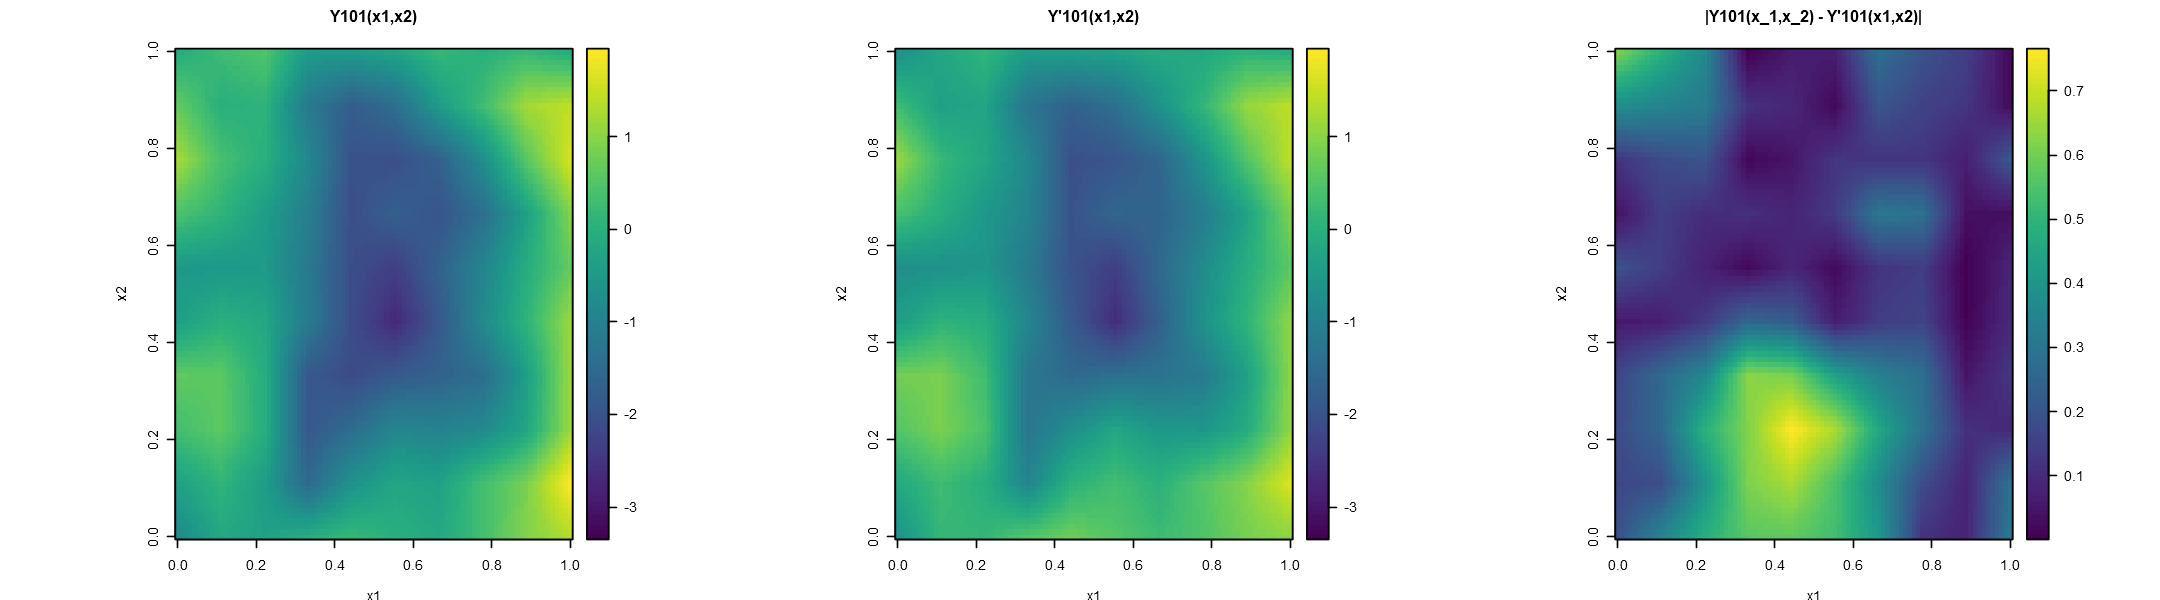

In [10]:
# plotting spatial profiles: truth, prediction, abs error #
zlim <- range(ysamp[[nrep]])*c(1.235, 1)

par(mfrow = c(1, 3))
options(repr.plot.width = 18, repr.plot.height = 5)

image2D(matrix(ysamp[[nrep]], nrow = length(x1D)), clim = zlim,
        x1D, x1D, resfac = 10, col = colormap,
        xlab = "x1", ylab = "x2", main = paste("Y",nrep,"(x1,x2)", sep = ""))

image2D(matrix(predOptKro$mean, nrow = length(x1D)), clim = zlim,
        x1D, x1D, resfac = 10, col = colormap,
        xlab = "x1", ylab = "x2", main = paste("Y'",nrep,"(x1,x2)", sep = ""))

image2D(matrix(abs(c(ysamp[[nrep]]) - predOptKro$mean), nrow = length(x1D)),
        x1D, x1D, resfac = 10, col = colormap, 
        xlab = "x1", ylab = "x2",
        main = paste("|Y",nrep,"(x_1,x_2) - Y'",nrep,"(x1,x2)|", sep = ""))

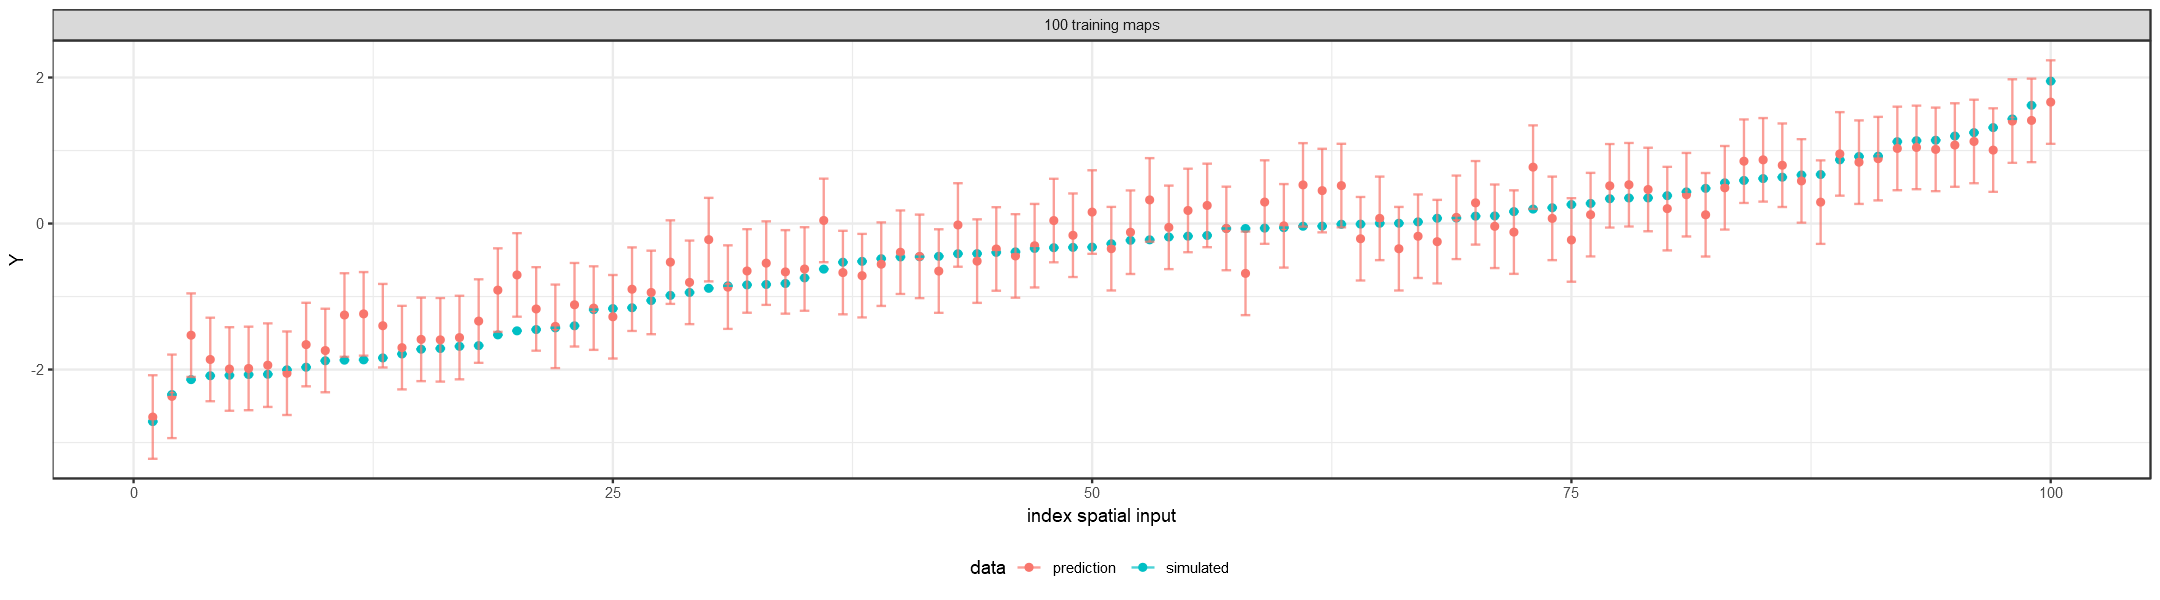

In [11]:
# checking the predictive confidence intervals #
idxsort <- sort(ysamp[[nrep]], index.return = TRUE)$ix
ggData <- data.frame(position = seq(nb_x^2),
                         magnitud = c(ysamp[[nrep]][idxsort], predOptKro$mean[idxsort]),
                         sd = c(rep(0, nb_x^2), predOptKro$sd[idxsort]),
                         data = rep(c("simulated", "prediction"), each = nb_x^2),
                         nbtrain =  paste(nrepTrain, "training maps"))

ggplot(ggData, aes(x = position, y = magnitud, color = data)) +
       geom_point() +
       geom_errorbar(aes(ymin = magnitud-2*sd, ymax = magnitud+2*sd), width = 1, alpha=0.7,
                     position = position_dodge(0)) + theme_bw() + theme(legend.position="bottom") +
  facet_wrap(facets = vars(nbtrain)) +
  labs(x = "index spatial input", y = "Y")